In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
base = np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/save_emb_rd_0_base.npy')
base = torch.from_numpy(base)
base.shape

torch.Size([49078, 1024])

In [3]:
base_lambdas = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/save_emb_rd_0_base.csv')
base_lambdas 

,lambdas_trained
0,0.016861
1,0.000000
2,0.000230
3,0.004169
4,0.004474
...,...
49073,0.012951
49074,0.034868
49075,0.008061
49076,0.002347


In [4]:
class lambdaset(Dataset):
    def __init__(self, X_train, X_test, y_train, y_test, train=True):

        if train:
            self.x_data, self.y_data = X_train, y_train
        else:
            self.x_data, self.y_data = X_test, y_test
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i], i

    def __len__(self):
        return self.y_data.shape[0]

In [5]:
class ResidualMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.out = nn.Sequential(
            nn.Linear(512, 1),
            nn.Softplus()
        )

    def forward(self, x):
        x = self.block1(x)
        res = x
        x = self.block2(x)
        x = x + res  # residual connection
        return self.out(x)

In [6]:
# Regression model
class RegressionHead(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(),

            nn.Linear(64, 32),
            nn.LeakyReLU(),

            nn.Linear(32, 16),
            nn.LeakyReLU(),

            nn.Linear(16, 1),
            nn.Softplus()  # Output remains positive, smooth version of ReLU
        )
    
    def forward(self, x):
        return self.model(x)

In [7]:
# Regression model
class RegressionHead(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 16),
            nn.LeakyReLU(),

            nn.Linear(16, 1),
            nn.Softplus()  
        )
    
    def forward(self, x):
        return self.model(x)

In [8]:
class ConvLambdaNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim * 32, 1),
            nn.Softplus()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # add channel dim
        x = self.conv(x)
        return self.fc(x)


In [9]:
# Dataset and loader
X = base
y = torch.tensor(base_lambdas.values, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1))

train_loader = DataLoader(lambdaset(X_train, X_test, y_train, y_test), batch_size=128, shuffle=True, drop_last=True)


model = RegressionHead(input_dim=1024)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.95)
y_test = scaler.transform(y_test)

# train and validation mse per batch
train_mse_ls = []
val_mse_ls = [] 

# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0
    iterator = iter(train_loader)
    mse = []
    print_every = 10
    for i in range(len(train_loader)):
        x, y, i = next(iterator)
        optimizer.zero_grad()
        preds = model(x).squeeze()
        loss = criterion(preds, y.squeeze().float())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        mse.append(mean_squared_error(y.squeeze().numpy(), preds.detach().numpy()))
    scheduler.step()

    batch_loss = total_loss / len(train_loader)
    batch_mse = sum(mse) / len(mse)

    train_mse_ls.append(batch_mse)
        
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze().cpu().numpy()
        val_mse = mean_squared_error(y_pred, y_test)
        val_mse_ls.append(val_mse)
        

    if epoch % print_every == 0:
        print(f"Epoch {epoch+1} | Loss: {batch_mse:.6f} | test MSE: {val_mse:.6f}") # mse on transformed scale

Epoch 1 | Loss: 0.009060 | test MSE: 0.005931
Epoch 11 | Loss: 0.005850 | test MSE: 0.005759
Epoch 21 | Loss: 0.005774 | test MSE: 0.005643
Epoch 31 | Loss: 0.005680 | test MSE: 0.005543
Epoch 41 | Loss: 0.005607 | test MSE: 0.005593
Epoch 51 | Loss: 0.005547 | test MSE: 0.005436
Epoch 61 | Loss: 0.005505 | test MSE: 0.005375
Epoch 71 | Loss: 0.005481 | test MSE: 0.005408
Epoch 81 | Loss: 0.005480 | test MSE: 0.005369
Epoch 91 | Loss: 0.005455 | test MSE: 0.005356


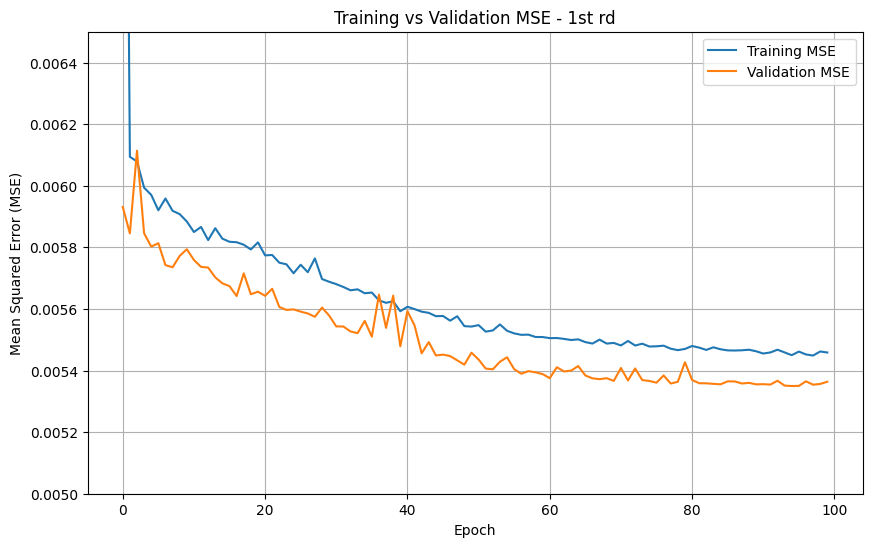

In [10]:
import matplotlib.pyplot as plt

epochs = range(100)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mse_ls, label='Training MSE')
plt.plot(epochs, val_mse_ls, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.ylim(0.0050, 0.0065)
plt.title('Training vs Validation MSE - 1st rd')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().cpu().numpy()
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    test_mse = mean_squared_error(y_pred, y_test)
    print(test_mse)


0.008865460269028727


In [12]:
model.eval()
with torch.no_grad():
    y_pred_held = model(held).squeeze().cpu().numpy()


NameError: name 'held' is not defined

In [ ]:
(len(y_pred_held) - np.count_nonzero(y_pred_held))/len(y_pred_held)

In [ ]:
len(y_pred_held[y_pred_held>0])/len(y_pred_held)

In [ ]:
sorted(y_pred_held, reverse=True)[:100]